# <center>CryptoPsychic</center>

!['CryptoKadabra'](crypto-kadabra.png)

The purpose of this project is to build an end-to-end pipeline that transforms market data, google search popularity, and crypto-related news articles into (hopefully lucrative) trade recommendations.

The main focus of my work will be on building a stable, automated system that collects information and predicts on a schedule, with recommendations being logged for profitability analysis.

Assuming that the process is running without major issues, the secondary focus will be on tuning the models to maximize accuracy/profitability

Models:
    - Tweet Classifier: Determines whether an article is worth scraping (i.e. related to crypto) based on the tweet text
    - Article NLP:      Determine the probability that certain news will have either a positive or negative effect on prices
    ~~- Price Predictor:  Estimate the future price of the currency~~ removed because its a bit unnessecary at this point
    - Buy/Hodl/Sell Classifier: Determine how the currency should be handled based on sentiment/price/predictions/etc.
    

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import twitter, re, datetime, requests, urllib.parse

from bs4 import BeautifulSoup
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.preprocessing import Normalizer, normalize

%matplotlib inline

## Scrapers

### Twitter

In [6]:
twitter_keys = {
    'consumer_key':        'Cy8Mfv4957WNDFHRtRWfC8Gqw',
    'consumer_secret':     'hHXb6evIvo5MbKtBPSaAHGq1avmZ40yHeR3xLNG7F5LUyDHw0f',
    'access_token_key':    '235599984-MTQpxnL7FqzZ7d4XDlb1AFWFDG2nM5JhKBMljtys',
    'access_token_secret': '1IygTdmOrDA7uBzjM90HKtt4i3y3NCMecRpmnlHHNsMng'
}

api = twitter.Api(
    consumer_key         =   twitter_keys['consumer_key'],
    consumer_secret      =   twitter_keys['consumer_secret'],
    access_token_key     =   twitter_keys['access_token_key'],
    access_token_secret  =   twitter_keys['access_token_secret']
)


class TweetMiner(object):
    result_limit = 20    
    api          = False
    data         = []
    
    def __init__(self, keys_dict, api, result_limit = 20):
        self.api          = api
        self.twitter_keys = keys_dict
        self.result_limit = result_limit

    def mine_user_tweets(self, users, mine_rewteets=False, max_pages=1):
        tweets           =  []
        
        for user in users:
            last_tweet_id  =  False
            page           =  1
            
            while page <= max_pages:
                if last_tweet_id:
                    user_tweets   =   self.api.GetUserTimeline(screen_name=user, count=self.result_limit, max_id=last_tweet_id - 1)        
                else:
                    user_tweets   =   self.api.GetUserTimeline(screen_name=user, count=self.result_limit)

                for item in user_tweets:
                    tweet = {
                        'id':         item.id,
                        'user':       item.user.name,
                        'text':       item.text,
                        'retweets':   item.retweet_count,
                        'favorites':  item.favorite_count,
                        'created_at': item.created_at
                    }
                    
                    tweet_data = [tweet['id'], tweet['user'],  tweet['text'], tweet['favorites'], tweet['retweets'], tweet['created_at']]
                    tweets.append(tweet_data)
                    last_tweet_id = item.id

                page += 1

        return tweets
        
    def get_tweets_from_search(self, search_terms):
        tweets = []
        
        for term in search_terms:
            search_tweets = self.api.GetSearch(raw_query="q={}".format(urllib.parse.quote_plus(term)))
            
            for item in search_tweets:
                tweet = {
                    'id':         item.id,
                    'user':       item.user.name,
                    'text':       item.text,
                    'favorites':  item.favorite_count,
                    'retweets':   item.retweet_count,
                    'created_at': item.created_at
                }
                
                tweet_data = [tweet['id'], tweet['user'], tweet['text'], tweet['favorites'], tweet['retweets'], tweet['created_at']]
                tweets.append(tweet_data)

        return tweets
    
twitter = TweetMiner(keys_dict=twitter_keys, api=api)

In [10]:
def scrape_currency():
    
    base_url = 'https://coinmarketcap.com'
    html = requests.get(base_url)
    soup = BeautifulSoup(html.content, 'lxml')
    currency_link_html = soup.find(id='currencies').find('tbody').find_all('tr')
    link_list = []
    for html in currency_link_html:
            link_list.append(html.find('a').attrs['href'])
    columns = []
    
    data_list = []
    
    for i, currency in enumerate(link_list[:1]):
        print(currency + ' is being scraped')
        url = 'https://coinmarketcap.com{}historical-data/?start=20180101&end=20180401'.format(currency)

        html = requests.get(url)
        soup = BeautifulSoup(html.content, 'lxml')
        table = soup.find('tbody')
        if i == 0:
            header = soup.find('thead').find_all('tr')[0].find_all('th') 
            for label in header:
                columns.append(label.text)

        for row in table.find_all('tr'):
            row_data = []

            for data in row.find_all('td'):
                try:
                    raw_val = data.attrs['data-format-value']
                except KeyError:
                    raw_val = data.text

                try:
                    row_data.append(float(raw_val))
                except ValueError:
                    row_data.append(raw_val)
            if row_data[-1] != '-':
                data_list.append(row_data)
    df = pd.DataFrame(data=data_list, columns=columns)
    df = df[:][:-1]
    df = df.reindex(index=df.index[::-1])
    
    df['Date'] = pd.to_datetime(df['Date'])
    df['Market Cap'] = pd.to_numeric(df['Market Cap'])
#     df['Percent Change'] = (df['Close'] - df['Open']) / df['Open']
    
    df.set_index('Date', inplace=True)
    
    return df

df = scrape_currency()

# class CmcScraper(object):
#     currencies = []    
#     base_url = 'https://coinmarketcap.com'
    
#     def __init__(self, currencies, base_url):
#         self.ignored_currencies = ignored_currencies
#         self.base_url = base_url

#     def mine_historic_data(self, currencies):
#         data =  []
        
#         for currency in currencies:
#             pass
        
#         return data

#     def daily_miner(self, currencies):
#         return data

/currencies/bitcoin/ is being scraped


In [11]:
df.head()

,Open,High,Low,Close,Volume,Market Cap
Date,,,,,,
2018-01-02,13625.0,15444.6,13163.6,14982.1,1.684660e+10,2.285790e+11
2018-01-03,14978.2,15572.8,14844.5,15201.0,1.687190e+10,2.513120e+11
2018-01-04,15270.7,15739.7,14522.2,15599.2,2.178320e+10,2.562500e+11
2018-01-05,15477.2,17705.2,15202.8,17429.5,2.384090e+10,2.597480e+11
2018-01-06,17462.1,17712.4,16764.6,17527.0,1.831460e+10,2.930910e+11


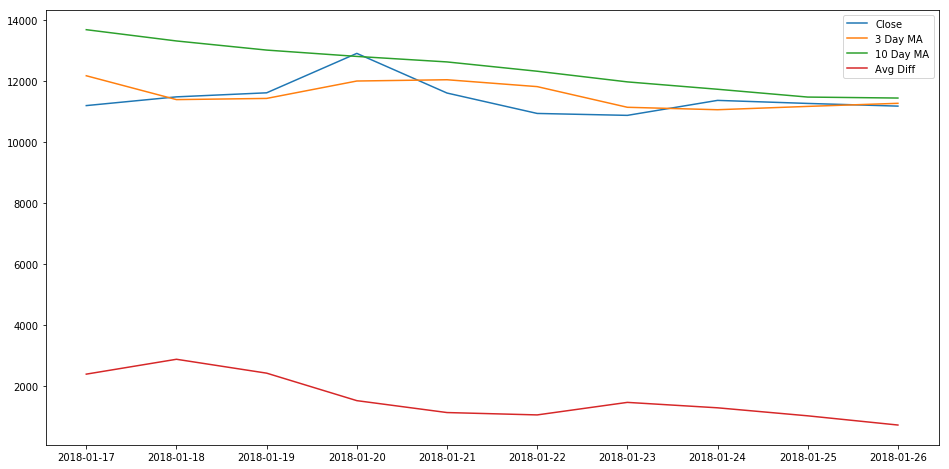

In [17]:
plt.figure(figsize=(16, 8))
plt.plot(df['Close'][15:25], label='Close')
plt.plot(df['Close'].rolling(3).mean()[15:25], label='3 Day MA')
plt.plot(df['Close'].rolling(10).mean()[15:25], label='10 Day MA')
plt.plot((df['Close'].rolling(14).mean() - df['Close'].rolling(3).mean())[15:25], label='Avg Diff')
plt.legend()

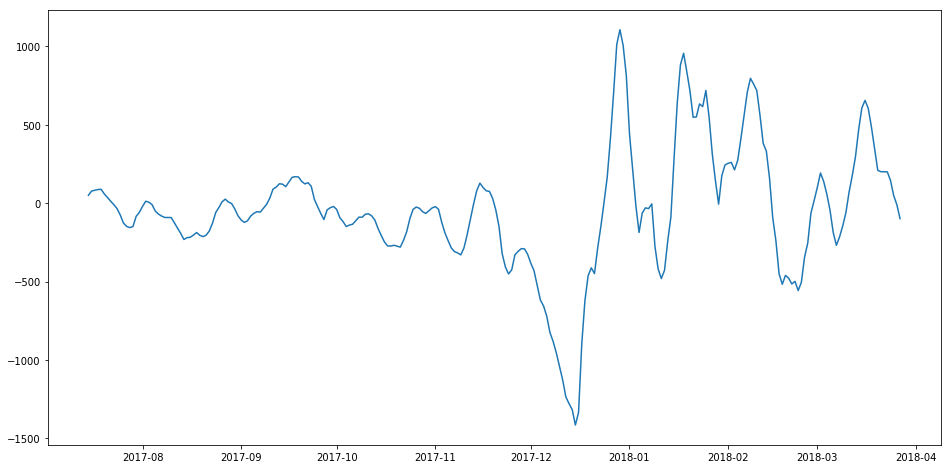

In [19]:
plt.figure(figsize=(16, 8))
plt.plot((df['Close'].rolling(14).mean() - df['Close'].rolling(10).mean()), label='Avg Diff')

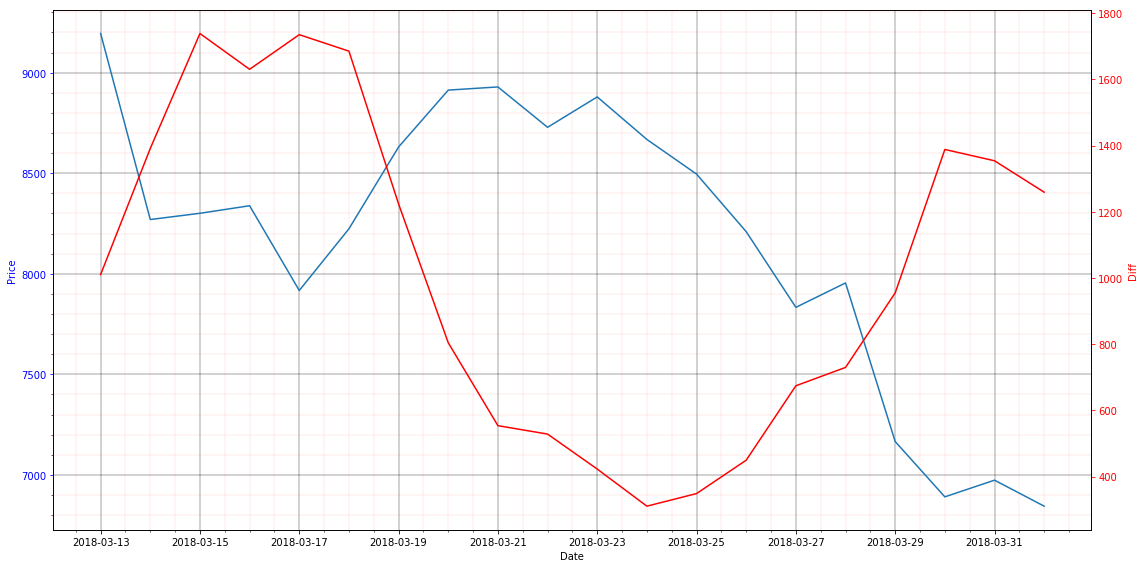

In [37]:
plt.figure(figsize=(16, 8))

fig, ax1 = plt.subplots(figsize=(16,8))
t = np.arange(0.01, 10.0, 0.01)
s1 = df['Close'][-20:]
ax1.plot(s1)
# ax1.plot(df['Close'].rolling(3).mean()[15:30], label='3 Day MA')
# ax1.plot(df['Close'].rolling(10).mean()[15:30], label='10 Day MA')
ax1.set_xlabel('Date')
ax1.set_ylabel('Price', color='b')
ax1.tick_params('y', colors='b')
ax1.minorticks_on()
ax1.grid(which='major', color='black', linestyle='-', linewidth='.35')
ax1.grid(which='minor', linestyle=':', linewidth='0.2', color='red')


ax5 = ax1.twinx()
s5 = (df['Close'].rolling(20).mean() - df['Close'].rolling(2).mean())[-20:]
ax5.plot(s5, 'r')
ax5.set_ylabel('Diff', color='r')
ax5.tick_params('y', colors='r')

fig.tight_layout()

plt.show()

In [13]:
one_day_ago = df.shift(1)
one_day_ago.columns = [column+'-1' for column in df.columns]

three_days_ago = df.shift(2)
three_days_ago.columns = [column+'-3' for column in df.columns]


In [14]:
train = pd.concat([one_day_ago, three_days_ago, df[['Open', 'Close']]], axis=1)
train.dropna(inplace=True)

features = [col for col in train.columns if not col == 'Close']
X = train[features]
y = train['Close']

etr = RandomForestRegressor()
cross_val_score(etr, X, y).mean()

-0.7870725598457203

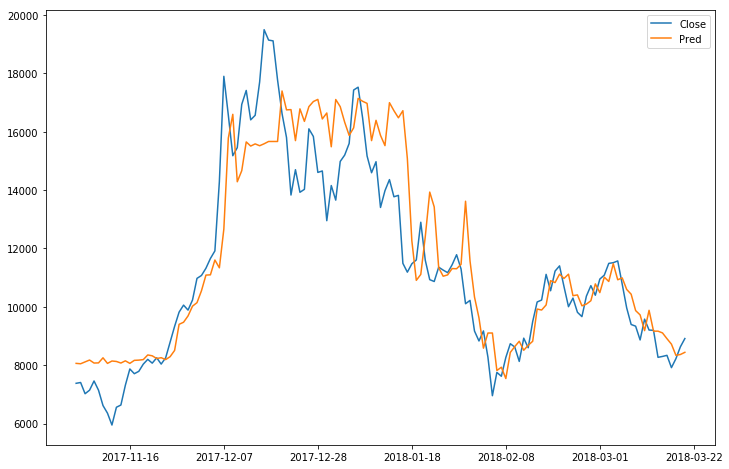

In [38]:
pred = cross_val_predict(etr, X, y)

temp = pd.concat([train[['Close']], pd.DataFrame(pred, columns=['Pred'], index=train.index)], axis=1)

plt.figure(figsize=(12, 8))
plt.plot(temp['Close'], label='Close')
plt.plot(temp['Pred'], label='Pred')
plt.legend()

In [39]:
percent_change_features = df.pct_change().shift()
percent_change_features.columns = [col + ' PCT Change' for col in percent_change_features.columns]

In [40]:
train = pd.concat([train, percent_change_features, df['Close'].rolling(30).mean()], axis=1)
train.dropna(inplace=True)
train.head()

,Open-1,High-1,Low-1,Close-1,Volume-1,Market Cap-1,Percent Change-1,Open-3,High-3,Low-3,...,Open,Close,Open PCT Change,High PCT Change,Low PCT Change,Close PCT Change,Volume PCT Change,Market Cap PCT Change,Percent Change PCT Change,Close
Date,,,,,,,,,,,,,,,,,,,,,
2017-12-01,9906.79,10801.0,9202.05,10233.6,8.310690e+09,1.655370e+11,0.032988,10077.40,11517.4,9601.03,...,10198.6,10975.6,-0.016930,-0.062202,-0.041556,0.034888,-0.281629,-0.016809,-2.760889,7953.409333
2017-12-02,10198.60,11046.7,9694.65,10975.6,6.783120e+09,1.704360e+11,0.076187,9906.79,10801.0,9202.05,...,10978.3,11074.6,0.029456,0.022748,0.053532,0.072506,-0.183808,0.029595,1.309501,8086.612667
2017-12-03,10978.30,11320.2,10905.10,11074.6,5.138500e+09,1.834900e+11,0.008772,10198.60,11046.7,9694.65,...,11082.7,11323.2,0.076452,0.024759,0.124858,0.009020,-0.242458,0.076592,-0.884864,8223.794000
2017-12-04,11082.70,11858.7,10862.00,11323.2,6.608310e+09,1.852580e+11,0.021700,10978.30,11320.2,10905.10,...,11315.4,11657.2,0.009510,0.047570,-0.003952,0.022448,0.286039,0.009635,1.473878,8366.369000
2017-12-05,11315.40,11657.2,11081.80,11657.2,6.132410e+09,1.891720e+11,0.030207,11082.70,11858.7,10862.00,...,11685.7,11916.7,0.020997,-0.016992,0.020236,0.029497,-0.072015,0.021127,0.391979,8516.678667


In [41]:
classification_ex = (train['Percent Change'] > 0).astype(int)

KeyError: 'Percent Change'

In [42]:
features = [col for col in train.columns if not col == 'Close']
X = train[features]
y = train['Close']

etr = RandomForestRegressor()
cross_val_score(etr, X, y).mean()

-0.5409074744472319

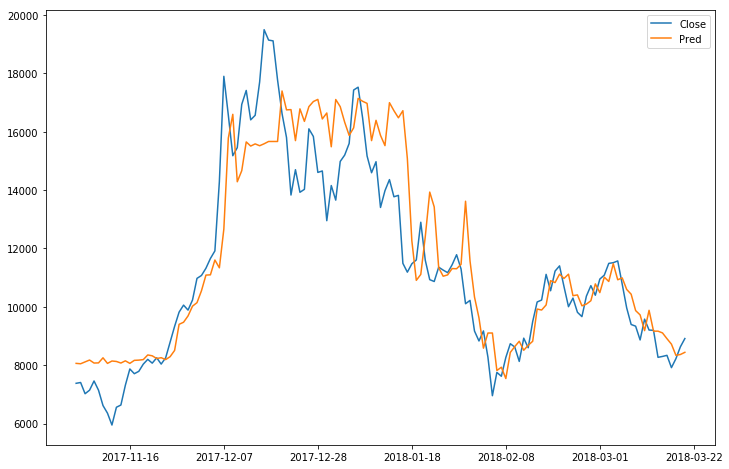

In [43]:
pred = cross_val_predict(etr, X, y)

plt.figure(figsize=(12, 8))
plt.plot(temp['Close'], label='Close')
plt.plot(temp['Pred'], label='Pred')
plt.legend()

In [44]:
normalized_df = normalize(df)

In [45]:
normalized_df.head()

AttributeError: 'numpy.ndarray' object has no attribute 'head'

In [46]:
def train_validate_test_split(normalized_df, train_part=.6, validate_part=.2, test_part=.2, seed=None):
    np.random.seed(seed)
    total_size = train_part + validate_part + test_part
    train_percent = train_part / total_size
    validate_percent = validate_part / total_size
    test_percent = test_part / total_size
    perm = np.random.permutation(normalized_df.index)
    m = len(normalized_df)
    train_end = int(train_percent * m)
    validate_end = int(validate_percent * m) + train_end
    train = perm[:train_end]
    validate = perm[train_end:validate_end]
    test = perm[validate_end:]
    return train, validate, test

In [47]:
train_size, valid_size, test_size = (80, 0, 20)
df_train, df_valid, df_test = train_validate_test_split(df,train_part=train_size,validate_part=valid_size,test_part=test_size,seed=2017)

In [48]:
df_y_train = df.loc[df_train, ['Close']]
df_x_train = df.loc[df_train, :].drop('Close', axis=1)
df_y_test = df.loc[df_test, ['Close']]
df_x_test = df.loc[df_test, :].drop('Close', axis=1)

print('Size of training set: ', len(df_x_train))
print('Size of test set: ', len(df_x_test))

Size of training set:  111
Size of test set:  28


In [49]:
def norm_stats(df1, df2):
    dfs = df1.append(df2)
    minimum = np.min(dfs)
    maximum = np.max(dfs)
    mu = np.mean(dfs)
    sigma = np.std(dfs)
    return (minimum, maximum, mu, sigma)

In [50]:
def z_score(col, stats):
    m, M, mu, s = stats
    df = pd.DataFrame()
    for c in col.columns:
        df[c] = (col[c]-mu[c])/s[c]
    return df

In [51]:
stats = norm_stats(df_x_train, df_x_test)
arr_x_train = np.array(z_score(df_x_train, stats))
arr_y_train = np.array(df_y_train)
arr_x_test = np.array(z_score(df_x_test, stats))
arr_y_test = np.array(df_y_test)

print('Training shape:', arr_x_train.shape)
print('Training samples: ', arr_x_train.shape[0])
print('Validation samples: ', arr_x_test.shape[0])

Training shape: (111, 6)
Training samples:  111
Validation samples:  28


In [52]:
def keras_model(x_size, y_size):
    t_model = Sequential()
    t_model.add(Dense(6, activation="tanh", input_shape=(x_size,)))
    t_model.add(Dropout(0.33))
    t_model.add(Dense(50, activation="relu", kernel_initializer='normal', 
        kernel_regularizer=regularizers.l1(0.01), bias_regularizer=regularizers.l1(0.01)))
    t_model.add(Dropout(0.5))
    t_model.add(Dense(10, activation="relu", kernel_initializer='normal'))
    t_model.add(Dropout(0.5))
    t_model.add(Dense(y_size))
    t_model.compile(
        loss='mean_squared_error',
        optimizer='nadam',
        metrics=[metrics.mae])
    return(t_model)


model = keras_model(arr_x_train.shape[1], arr_y_train.shape[1])
model.summary()

epochs = 10
batch_size = 1500000

print('Epochs: ', epochs)
print('Batch size: ', batch_size)

history = model.fit(arr_x_train, arr_y_train,
    batch_size =      batch_size,
    epochs =          epochs,
    shuffle =         True,
    verbose =         1,
    validation_data = (arr_x_test, arr_y_test)
                   )

train_score = model.evaluate(arr_x_train, arr_y_train, verbose=0)
valid_score = model.evaluate(arr_x_test, arr_y_test, verbose=0)

print('Train MAE: ', round(train_score[1], 4), ', Train Loss: ', round(train_score[0], 4)) 
print('Val MAE: ', round(valid_score[1], 4), ', Val Loss: ', round(valid_score[0], 4))

def plot_hist(h, xsize=6, ysize=10):
    # Prepare plotting
    fig_size = plt.rcParams["figure.figsize"]
    plt.rcParams["figure.figsize"] = [xsize, ysize]
    fig, axes = plt.subplots(nrows=4, ncols=4, sharex=True)
    
    # summarize history for MAE
    plt.subplot(211)
    plt.plot(h['mean_absolute_error'])
    plt.plot(h['val_mean_absolute_error'])
    plt.title('Training vs Validation MAE')
    plt.ylabel('MAE')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    # summarize history for loss
    plt.subplot(212)
    plt.plot(h['loss'])
    plt.plot(h['val_loss'])
    plt.title('Training vs Validation Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    # Plot it all in IPython (non-interactive)
    plt.draw()
    plt.show()

    return

plot_hist(history.history, xsize=8, ysize=12)



NameError: name 'Sequential' is not defined

In [ ]:
normalized_df = pd.DataFrame(normalized_df)
normalized_df.columns = df.columns
normalized_df.head()

In [53]:
# pred = cross_val_predict(model, X, y)

features = [col for col in df.columns if not col == 'Close']
X = normalized_df[features]
model.predict(X)

# plt.figure(figsize=(12, 8))
# plt.plot(temp['Close'], label='Close')
# plt.plot(temp['Pred'], label='Pred')
# plt.legend()


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [54]:
X.head()

,Open-1,High-1,Low-1,Close-1,Volume-1,Market Cap-1,Percent Change-1,Open-3,High-3,Low-3,...,Market Cap-3,Percent Change-3,Open,Open PCT Change,High PCT Change,Low PCT Change,Close PCT Change,Volume PCT Change,Market Cap PCT Change,Percent Change PCT Change
Date,,,,,,,,,,,,,,,,,,,,,
2017-12-01,9906.79,10801.0,9202.05,10233.6,8.310690e+09,1.655370e+11,0.032988,10077.40,11517.4,9601.03,...,1.683670e+11,-0.018734,10198.6,-0.016930,-0.062202,-0.041556,0.034888,-0.281629,-0.016809,-2.760889
2017-12-02,10198.60,11046.7,9694.65,10975.6,6.783120e+09,1.704360e+11,0.076187,9906.79,10801.0,9202.05,...,1.655370e+11,0.032988,10978.3,0.029456,0.022748,0.053532,0.072506,-0.183808,0.029595,1.309501
2017-12-03,10978.30,11320.2,10905.10,11074.6,5.138500e+09,1.834900e+11,0.008772,10198.60,11046.7,9694.65,...,1.704360e+11,0.076187,11082.7,0.076452,0.024759,0.124858,0.009020,-0.242458,0.076592,-0.884864
2017-12-04,11082.70,11858.7,10862.00,11323.2,6.608310e+09,1.852580e+11,0.021700,10978.30,11320.2,10905.10,...,1.834900e+11,0.008772,11315.4,0.009510,0.047570,-0.003952,0.022448,0.286039,0.009635,1.473878
2017-12-05,11315.40,11657.2,11081.80,11657.2,6.132410e+09,1.891720e+11,0.030207,11082.70,11858.7,10862.00,...,1.852580e+11,0.021700,11685.7,0.020997,-0.016992,0.020236,0.029497,-0.072015,0.021127,0.391979


In [55]:
df.head()

,Open,High,Low,Close,Volume,Market Cap,Percent Change
Date,,,,,,,
2017-11-02,6777.77,7367.33,6758.72,7078.50,4.653770e+09,1.129100e+11,0.044370
2017-11-03,7087.53,7461.29,7002.94,7207.76,3.369860e+09,1.180840e+11,0.016964
2017-11-04,7164.48,7492.86,7031.28,7379.95,2.483800e+09,1.193760e+11,0.030075
2017-11-05,7404.52,7617.48,7333.19,7407.41,2.380410e+09,1.233880e+11,0.000390
2017-11-06,7403.22,7445.77,7007.31,7022.76,3.111900e+09,1.233790e+11,-0.051391


In [56]:
df.dtypes

Open              float64
High              float64
Low               float64
Close             float64
Volume            float64
Market Cap        float64
Percent Change    float64
dtype: object